# Denoising Autoencoder
First, we import in all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation

In [2]:
%tensorflow_version 2.x
%matplotlib inline

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Loading in our Data
We load in the data from our Drive and process it to according to the input expected by Keras models

In [4]:
#colab-related
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
X_train = np.load('/content/gdrive/My Drive/613_denoising/X_train.npy', allow_pickle=True)
noisy_X_train = np.load('/content/gdrive/My Drive/613_denoising/noisy_X_train.npy', allow_pickle=True)

X_val = np.load('/content/gdrive/My Drive/613_denoising/X_val.npy', allow_pickle=True)
noisy_X_val = np.load('/content/gdrive/My Drive/613_denoising/noisy_X_val.npy', allow_pickle=True)

X_test = np.load('/content/gdrive/My Drive/613_denoising/X_test.npy', allow_pickle=True)
noisy_X_test = np.load('/content/gdrive/My Drive/613_denoising/noisy_X_test.npy', allow_pickle=True)

In [6]:
X_train = np.reshape( X_train/255, (-1,28,28,1))
noisy_X_train = np.reshape( noisy_X_train/255, (-1,28,28,1))

X_val = np.reshape( X_val/255, (-1,28,28,1))
noisy_X_val = np.reshape( noisy_X_val/255, (-1,28,28,1))

X_test = np.reshape( X_test/255, (-1,28,28,1))
noisy_X_test = np.reshape( noisy_X_test/255, (-1,28,28,1))

In [7]:
print(X_train.shape, '\t', noisy_X_train.shape)
print(X_val.shape, '\t', noisy_X_val.shape)
print(X_test.shape, '\t', noisy_X_test.shape)

(45000, 28, 28, 1) 	 (45000, 28, 28, 1)
(15000, 28, 28, 1) 	 (15000, 28, 28, 1)
(10000, 28, 28, 1) 	 (10000, 28, 28, 1)


## Model Architecture

In [59]:
input = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(128, (3, 3), strides=2, padding="same")(input)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)

# Latent space
op_size = K.int_shape(x) 
x = Flatten()(x)
latent = Dense(64)(x)

x = Dense(np.prod(op_size[1:]))(latent)
x = Reshape(op_size[1:])(x)

# Decoder
x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(1, (3, 3), padding="same")(x)
output = Activation("sigmoid")(x)

# Autoencoder
autoencoder = keras.Model(input, x)
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 batch_normalization_70 (Bat  (None, 14, 14, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_36 (Conv2D)          (None, 7, 7, 64)          73792     
                                                                 
 leaky_re_lu_71 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                          

## Model Training

In [60]:
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [61]:
checkpoint = keras.callbacks.ModelCheckpoint('model_ae.h5', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_ssim_loss')

opt = keras.optimizers.Adam()
autoencoder.compile(optimizer=opt, loss="mean_squared_error", metrics = [ssim_loss])

In [62]:
history = autoencoder.fit(noisy_X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(noisy_X_val, X_val), callbacks=[checkpoint, earlystop])

Epoch 1/10
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0207 - ssim_loss: 0.5535 - val_loss: 0.0111 - val_ssim_loss: 0.6654
Epoch 2/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.0106 - ssim_loss: 0.6718 - val_loss: 0.0202 - val_ssim_loss: 0.6892
Epoch 3/10
1407/1407 [==============================] - 13s 10ms/step - loss: 0.0093 - ssim_loss: 0.7105 - val_loss: 0.0129 - val_ssim_loss: 0.6945
Epoch 4/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.0086 - ssim_loss: 0.7264 - val_loss: 0.0110 - val_ssim_loss: 0.7271
Epoch 5/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.0081 - ssim_loss: 0.7370 - val_loss: 0.0085 - val_ssim_loss: 0.7354
Epoch 6/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.0078 - ssim_loss: 0.7430 - val_loss: 0.0148 - val_ssim_loss: 0.6685


## Model Evaluation

In [63]:
autoencoder.evaluate(noisy_X_test, X_test, batch_size=32)

313/313 [==============================] - 2s 6ms/step - loss: 0.0112 - ssim_loss: 0.6632


[0.01117816660553217, 0.6631856560707092]

In [69]:
np.mean(tf.image.psnr(X_pred, X_test, max_val=1))

20.021397

In [64]:
X_pred = autoencoder.predict(noisy_X_test)

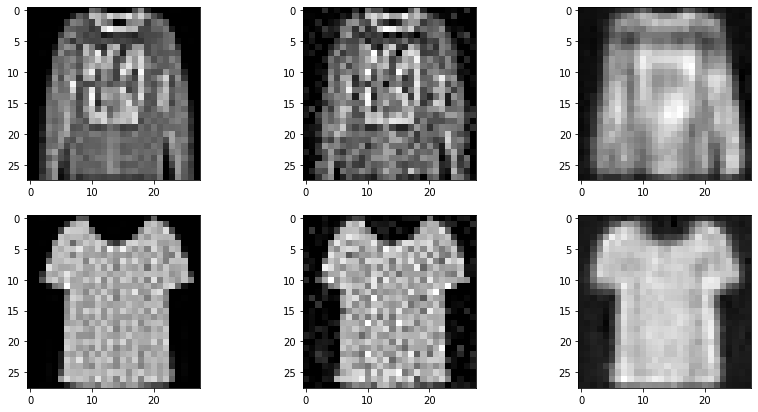

In [70]:
choice = 500

fig, ax = plt.subplots(2,3, figsize=(14,7))

ax[0][0].imshow(X_test[choice,:,:,:].reshape(28,28), cmap='gray')
ax[0][1].imshow(noisy_X_test[choice,:,:,:].reshape(28,28), cmap='gray')
ax[0][2].imshow(X_pred[choice,:,:,:].reshape(28,28), cmap='gray')

ax[1][0].imshow(X_test[choice*2,:,:,:].reshape(28,28), cmap='gray')
ax[1][1].imshow(noisy_X_test[choice*2,:,:,:].reshape(28,28), cmap='gray')
ax[1][2].imshow(X_pred[choice*2,:,:,:].reshape(28,28), cmap='gray')

As seen above, the model does remove most of the noise but a slight blur is present which causes loss of minute information like the pattern on the tshirts.